# Sequencing data analysis

## Reference genomes 

A reference genome comes in a file format called fasta, usually with the extension `.fa`, and plain text (or compressed with `.gz`).

This file is nothing but a string of letters, representing a sequence (e.g. a genome of ~3.5 Gbp). Too big to download individually, hence we can use it in one directory.

```
cd /lisc/scratch/course/2024w550001/
less ref_gen/hg19.fa
```

* We should do some inspections here!

Let's put this into a variable for convenience, and everyone please create your own directory with `mkdir`!

```
WDIR=/lisc/scratch/course/2024w550001/
REF=$WDIR/ref_gen/hg19.fa
```

## Raw sequencing data

*Now, let's look at some data!* Fastq files contain the raw sequencing data. Here is a small example data set.

```
less $WDIR/share/test.fastq.gz
```

So, you see here:

Header: read id, sequence info, read pair

Sequence: ATGCGCGTATCGATGCTATGC… bla bla

Qualities: confidence for each base called (ASCII)

**What do we do now?**

* Count the number of reads, or lines in the fasta file. How do they relate?

* Look at the start and end of the file.

* Search for patterns. E.g. "CGTATGCCGTCTTCTGCTTG" - what is going on? And why does it matter?


# Adapter trimming

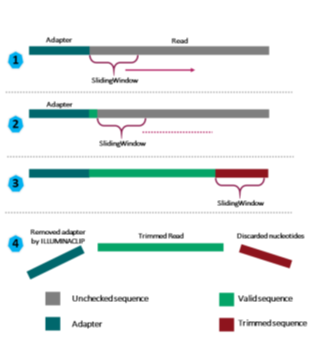

For trimming, we use a tool called `trimmomatic`, one of the possible tools for this taks. This is a tool implemented in a language called `java`, and we will not check how this looks like. On the good side, it is a command line tool, so you can used it the same way as you do with `grep` or other basic commands, providing parameters, and directions from where to take input and where to write output. These are some standard parameters (but of course, with new data, you may need to do adjustments):

```
module load trimmomatic
```

```
trimmomatic SE -phred33 $WDIR/share/test.fastq.gz test_p.fastq.gz \
LEADING:3 TRAILING:3 SLIDINGWINDOW:4:15 MINLEN:36
``` 

* Let's count the reads before and after this step!

Now we have performed the first important step in raw data filtering!


# FASTQC

Before moving on, let's have quick check on the raw data quality! In order to do that, we can use a program called FastQC. It is already installed on the cluster, and we can run it easily:

```
module load fastqc
```

``` 
mkdir fastqc-output
fastqc -o ./fastqc-output $WDIR/share/test.fastq.gz
```

This will create a report on data quality in `html` format, which we can inspect.

Now we have made sure the data looks good.

# Mapping of sequencing data

That is, finding where in the genome a short sequencing fragment belongs.

Doing that for millions of lines is a challenge - algorithmic abbreviations. The most commonly used command line tool is called `bwa`, find [here](https://bio-bwa.sourceforge.net/bwa.shtml) the documentation. 

## **BWA**

This tool has several different algorithms. The most commonly used one is `bwa mem`. Note that here we use that one because it is the easiest, but the sample data is (semi-)ancient, and in practice a different algorithm would be favourable.

You provide a reference genome to align to. Actually, this one has to be *indexed* first, meaning a "guide" to the "map" is created. This "guide" looks the same for a given reference genome, so it just needs to be created once, and you can download a [ready-made index](https://hgdownload.soe.ucsc.edu/goldenPath/hg19/bigZips/analysisSet/). It is already in the same directory as the reference genome. So please don't download it now, you can use the one that is there.

Then, you point to the index and map your `fastq` file:

```
module load bwa
```


(DON'T DO!)
```
#bwa mem -R '@RG\tID:1\tSM:1' $REF test_p.fastq.gz > test.sam
```

This would create as output a **SAM file** - a file that contains the sequence and its coordinates on the 23 chromosomes. Please, *never* create a SAM file! It is extremely inefficient, and the output of bwa should immediately piped into another tool in order to get a **BAM file** or **CRAM file** (compressed). However, they are different from zipped (`.gz`) files, but *binary* files instead. That means, they use a different (more basal) encoding, and cannot be accessed by with usual text processing tools such as `grep`.


## SAM/BAM files

Now, we have created a sequencing alignment file:


samtools sort | samtools view -b -o test.sorted.bam
It contains more than just the sequence information:

* Read information
* Position in the genome
* Mapping quality
* Information from FASTQ (Sequence & quality)
* CIGAR (alignment)
* Other stuff

* How do we get such a file?
* More generally, how do we process and access SAM/BAM/CRAM files?


### [**SAMTOOLS**](http://www.htslib.org/doc/samtools.html)

NOW DO:
```
module load samtools
```

```
bwa mem -R '@RG\tID:1\tSM:1' $REF test_p.fastq.gz | samtools sort | samtools view -b -o test.sorted.bam
```

Note that we use the variable defined earlier for the reference genome.

This will perform the mapping of sequencing reads to the reference, immediately sort the output and write it into a compressed bam file. No intermediate files, which is nice. Let's have a look!


```
samtools view test.bam
```

**STOP!**

What `samtools view` is doing here is similar to `cat`, just spitting all lines on the command line. That means, it becomes raw text, which can be piped and processed like any other text. 

```
samtools view test.bam | less

samtools view test.bam | grep "CATTTGGAA" | wc -l
```

The file should have a header, but here you just look at the content of the file, not the metadata.

```
samtools view -h test.bam | less

samtools view -H test.bam 
```

* You may inspect this file a bit!

Let's create an index to make things easy:

```
samtools index test.sorted.bam
```

## Filtering with samtools

We can use `samtools` to do quality filtering. Assume you want to only keep reads with an insert size of at least 35 base pairs (why would that be the case?) and a mapping quality score of at least 25. Then, the way to go is:

```
samtools view -b -m 35 -q 25 -o test.sorted.filtered.bam test.sorted.bam
```

* Now, count the number of reads, and compare to the unfiltered number of reads.
* What do you observe?

Unmapped reads can be removed with:

```
samtools view -b -F 4 -o test.sorted.justmapped.bam test.sorted.bam
```

Of course, the filter `-m 35` will do something similar, as unmapped reads will have no insert size.

## Merging with samtools

Often, you will have sequencing data from different sequencing runs. Usually, you want to treat each of them separately for adapter cutting, mapping and QC, but merge them for downstream analyses. Just adding one file at the end of the other, however, may lead to problems, considering that there are headers and metadata and stuff. `samtools` has a nice function to deal with this and create proper merged datasets. If you had another bam file, you would do:

```
samtools merge -o test.merged.bam test.sorted.bam test3.sorted.bam 
samtools index test.merged.bam 
```

# Duplicates

For sequencing, during library preparation, there is a PCR step, leading to the occurrence of some PCR duplicates in the data. This is not biologically meaningful data, so one may want to remove them. There are different strategies, some just mark them in the data but leave it there, while others straightforward remove them.

In principle, you could write a little script to get unique sequences (`uniq`), ask if they are at the same location (with `awk`), and remove them from the data. However, the process is a bit complicated, so it is better to rely on existing tools. One of the tools for this purpose is part of the GenomeAnalysisToolKit (GATK): `gatk MarkDuplicates`. We will work more with this toolkit later on. It is the main toolkit for many tasks related to genetic data, and knowing the duplicates is an important feature.

```
module load gatk
```

Now, let's try the following:

```
gatk MarkDuplicates --REMOVE_DUPLICATES -I test.sorted.filtered.bam -O test.rmdup.sorted.filtered.bam -M metrics0.txt
```

Well, this is not such a great dataset. But if you work with aDNA, this is what you might expect...
